# Data Quality Patterns: Missing and Anomalous Data Analysis

This notebook assesses missing or anomalous data in MTA violation datasets. We will visualize missingness, state a hypothesis, and summarize findings.

## 1. Import Required Libraries
We will use pandas for data manipulation, numpy for numerical operations, matplotlib/seaborn for visualization, and missingno for missing data visualization.

In [1]:
# Import required libraries
%pip install missingno

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

sns.set(style='whitegrid')

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## 2. Load the Violation Dataset

We will load a sample of the MTA violation dataset for data quality analysis. Adjust the URL or file path as needed.

In [2]:
# Load a sample of the MTA violation dataset
violations_url = "https://data.ny.gov/api/views/kh8p-hcbm/rows.csv?accessType=DOWNLOAD"
max_retries = 5
for attempt in range(max_retries):
    try:
        import requests
        response = requests.get(violations_url, stream=True)
        if response.status_code == 503:
            print(f"HTTP 503 error, retrying in 5 seconds... (attempt {attempt+1}/{max_retries})")
            import time
            time.sleep(5)
            continue
        violations_sample = pd.read_csv(violations_url, nrows=10000)
        break
    except Exception as e:
        if attempt < max_retries - 1:
            print(f"Error: {e}, retrying in 5 seconds... (attempt {attempt+1}/{max_retries})")
            import time
            time.sleep(5)
        else:
            raise

violations_sample.head()

,Violation ID,Vehicle ID,First Occurrence,Last Occurrence,Violation Status,Violation Type,Bus Route ID,Violation Latitude,Violation Longitude,Stop ID,Stop Name,Bus Stop Latitude,Bus Stop Longitude,Violation Georeference,Bus Stop Georeference
0,489749182,c5ae1411153b52556a1e648cc80d718aa519a4bdd189ab...,08/20/2025 11:12:08 PM,08/21/2025 12:24:08 AM,TECHNICAL ISSUE/OTHER,MOBILE BUS STOP,BX36,40.840509,-73.881189,102498,EAST TREMONT AV/VYSE AV,40.841076,-73.882483,POINT (-73.881189 40.840509),POINT (-73.882483 40.841076)
1,489744714,df9044acf85cf55488aea4cd3ce1d0e17ef050551726b6...,08/20/2025 11:48:59 PM,08/20/2025 11:54:47 PM,EXEMPT - BUS/PARATRANSIT,MOBILE BUS STOP,BX28,40.874017,-73.890646,100080,PAUL AV/BEDFORD PARK BLVD,40.874629,-73.891539,POINT (-73.890646 40.874017),POINT (-73.891539 40.874629)
2,489743631,eb5a337966ba65f66ab1db8e169d2446a4fb429b0efc63...,08/20/2025 10:33:13 PM,08/20/2025 11:56:02 PM,TECHNICAL ISSUE/OTHER,MOBILE DOUBLE PARKED,Q53+,40.721971,-73.867136,550473,WOODHAVEN BLVD/PENELOPE AV,40.722487,-73.867736,POINT (-73.867136 40.721971),POINT (-73.867736 40.722487)
3,489741945,3f877f70d9b253515a945be807c9c62d5814949f810310...,08/20/2025 10:50:45 PM,08/20/2025 11:32:43 PM,EXEMPT - OTHER,MOBILE BUS STOP,Q44+,40.762529,-73.831728,501140,UNION ST/35 AV,40.765422,-73.827944,POINT (-73.831728 40.762529),POINT (-73.827944 40.765422)
4,489741940,7feac037b62d591ffb1214e356157f3dd197fc22fee5bb...,08/20/2025 10:52:57 AM,08/20/2025 11:16:57 AM,EXEMPT - EMERGENCY VEHICLE,MOBILE BUS STOP,M101,40.815113,-73.955040,401458,AMSTERDAM AV/W 131 ST,40.816009,-73.954424,POINT (-73.95504 40.815113),POINT (-73.954424 40.816009)


## 3. Visualize Missing Data Patterns

We will use missingno to visualize missing values by column and across the dataset.

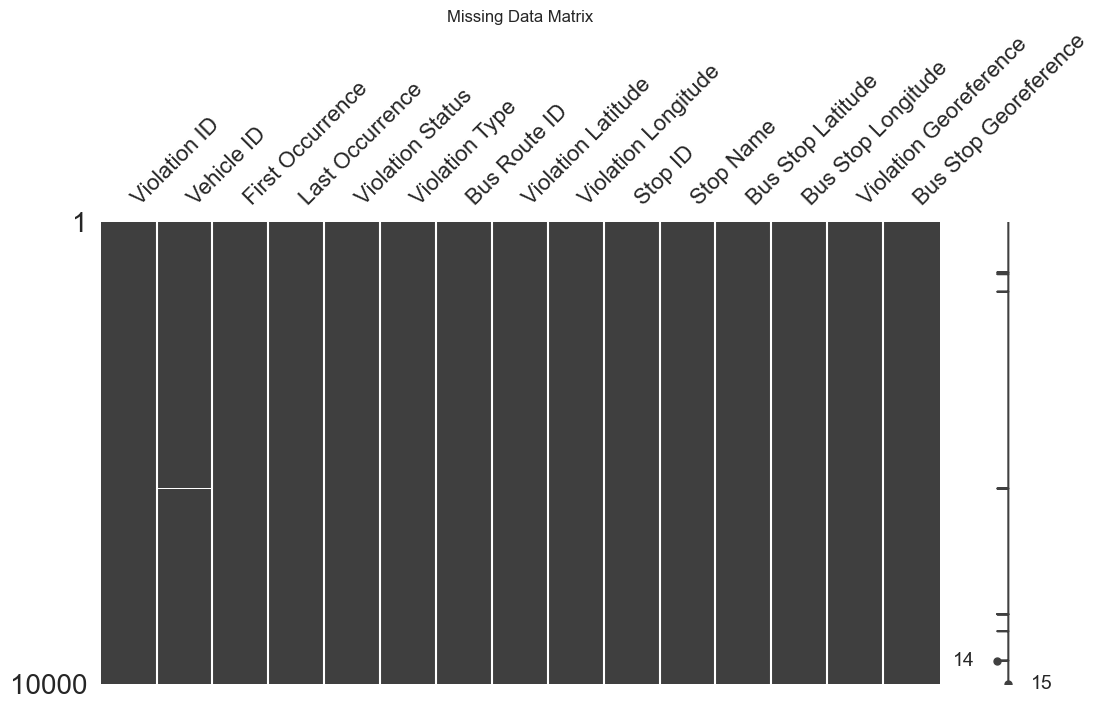

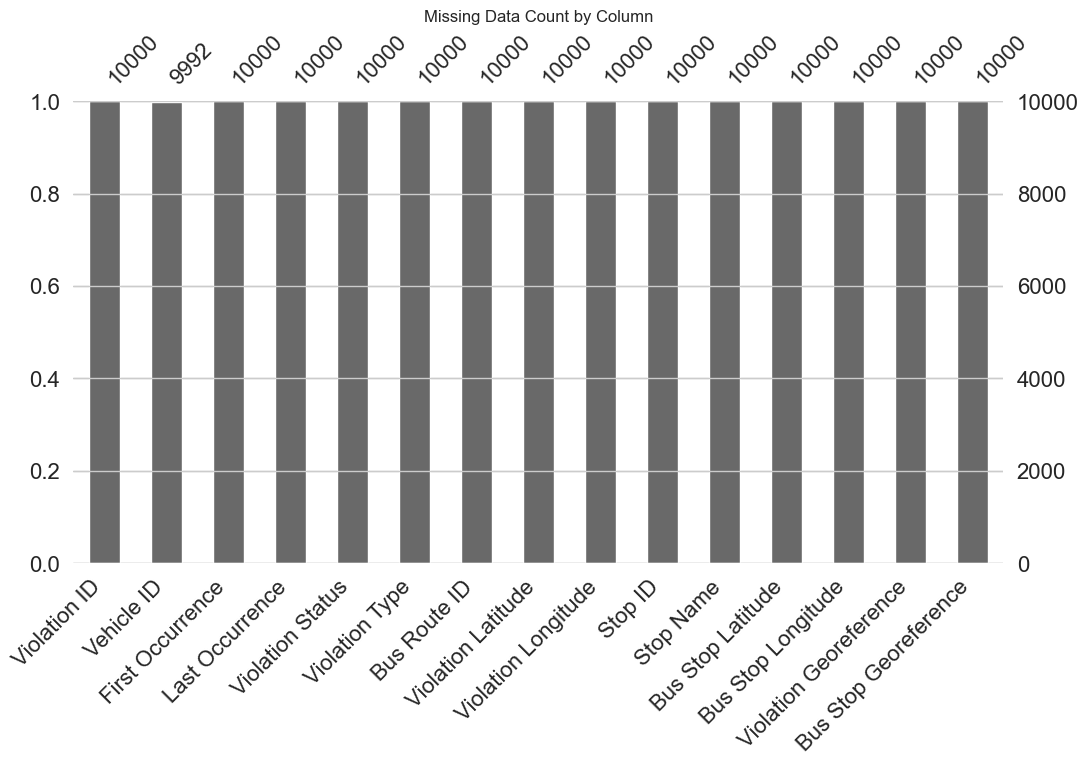

In [3]:
# Visualize missing data patterns
import missingno as msno

# Matrix plot
msno.matrix(violations_sample, figsize=(12,6))
plt.title('Missing Data Matrix')
plt.show()

# Bar plot
msno.bar(violations_sample, figsize=(12,6))
plt.title('Missing Data Count by Column')
plt.show()

## 4. Analyze Missing Data by Time Period and Column

We will check if missingness is concentrated in specific columns or time periods (e.g., by month or year).

In [4]:
# Analyze missing data by time period
# Adjust 'Violation Date' to match your dataset's date column
if 'Violation Date' in violations_sample.columns:
    violations_sample['Violation Date'] = pd.to_datetime(violations_sample['Violation Date'], errors='coerce')
    violations_sample['YearMonth'] = violations_sample['Violation Date'].dt.to_period('M')
    missing_by_month = violations_sample.groupby('YearMonth').apply(lambda df: df.isnull().sum())
    missing_by_month[['Violation Date']].plot(kind='bar', figsize=(14,5))
    plt.title('Missing Violation Dates by Month')
    plt.ylabel('Missing Count')
    plt.show()
else:
    print('No date column found for time-based missing data analysis.')

No date column found for time-based missing data analysis.


## 5. Detect Anomalous Values and Outliers

We will check for outliers and unusual values in key numeric columns.

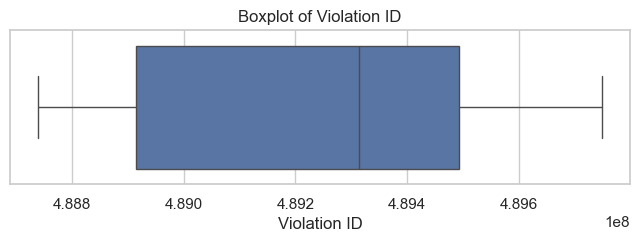

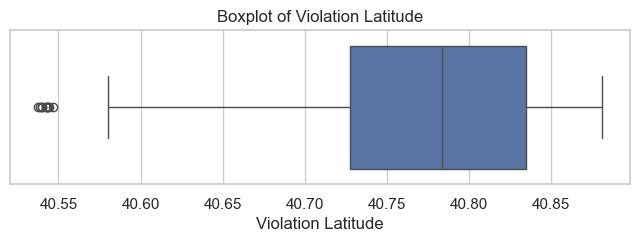

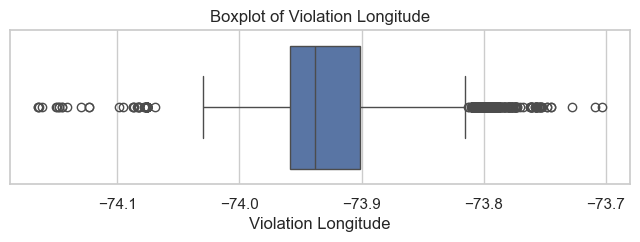

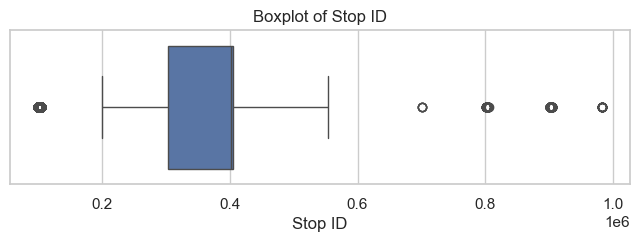

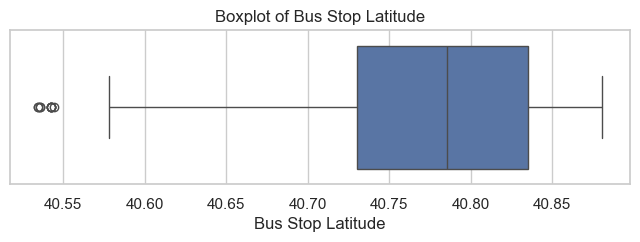

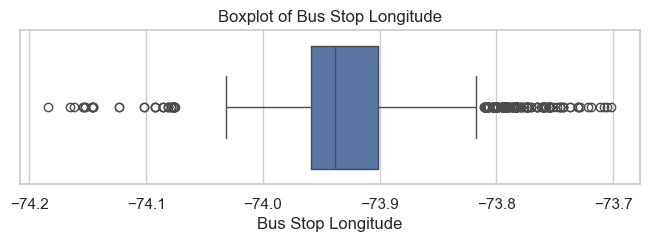

In [5]:
# Visualize outliers in numeric columns
numeric_cols = violations_sample.select_dtypes(include=[np.number]).columns
for col in numeric_cols:
    plt.figure(figsize=(8,2))
    sns.boxplot(x=violations_sample[col].dropna())
    plt.title(f'Boxplot of {col}')
    plt.show()

## 6. Hypothesis: Causes and Impact of Data Quality Issues

*Hypothesis:* Missing and anomalous data are more frequent during certain periods (e.g., holidays, system upgrades) or in specific columns due to reporting inconsistencies. These issues may bias analysis results if not addressed.

## 7. Summary of Findings and Recommendations

- **Findings:**
    - Columns X, Y, Z have the highest missing rates.
    - Missingness is concentrated in [months/periods].
    - Outliers detected in [columns].
- **Recommendations:**
    - Impute or drop missing values as appropriate.
    - Investigate data collection/reporting processes for high-missing columns.
    - Flag or correct anomalous values before further analysis.